## Final Project 
## Brainster DS x Parkinson's Disease Specifications

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix,recall_score,precision_score,roc_curve,auc,roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from catboost import CatBoostClassifier,Pool


### Import data from DataLoad nootbook

In [2]:
df_users = pd.read_csv("df_user.csv")
df_keys = pd.read_csv("df_keys.csv")

### Agregate data on HoldTime and LatencyTime by user
#### Create new features 

In [3]:
hold_by_user =  df_keys[df_keys['Hand'] != 'S'].groupby(['ID', 'Hand'])['HoldTime'].agg(['mean','std', skew, kurtosis])
latency_by_user = df_keys[np.in1d(df_keys['Direction'], ['LL', 'LR', 'RL', 'RR'])].groupby(['ID', 'Direction'])['LatencyTime'].agg(['mean','std',skew, kurtosis])

hold_by_user_flat = hold_by_user.unstack()
hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]
hold_by_user_flat['mean_hold_diff'] = hold_by_user_flat['mean_L'] - hold_by_user_flat['mean_R']

latency_by_user_flat = latency_by_user.unstack()
latency_by_user_flat.columns = ['_'.join(col).strip() for col in latency_by_user_flat.columns.values]
latency_by_user_flat['mean_LR_RL_diff'] = latency_by_user_flat['mean_LR'] - latency_by_user_flat['mean_RL']
latency_by_user_flat['mean_LL_RR_diff'] = latency_by_user_flat['mean_LL'] - latency_by_user_flat['mean_RR']



### Merge data

In [4]:
combined = pd.concat([hold_by_user_flat, latency_by_user_flat], axis=1)
full_set = pd.merge(combined.reset_index(), df_users[['ID', 'Parkinsons']], on='ID')
full_set.set_index('ID', inplace=True)
full_set.dropna(inplace=True)

In [5]:
full_set['Parkinsons'] = full_set['Parkinsons'].astype(int)


#### Save data

In [6]:
full_set.to_csv('Full_set_LDA.csv',index=False)

### Train model

In [7]:
X = full_set.drop(columns=['Parkinsons'])
y = full_set['Parkinsons']

#### Split data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(full_set.drop(columns=['Parkinsons']), full_set['Parkinsons'], test_size=0.2, random_state=42)

#### LDA Linear Discriminant Analysis

In [9]:
lda_model = LDA()
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [10]:
X_train = lda_model.transform(X_train)
X_test = lda_model.transform(X_test)

In [11]:
train_data = Pool(data=X_train, label=y_train)
test_data = Pool(data=X_test, label=y_test)

#### Save LDA model

In [12]:
filename = 'LDA_model.sav'
pickle.dump(lda_model, open(filename, 'wb'))

#### Train CatBoost model

In [13]:
model_cat = CatBoostClassifier(learning_rate=0.03,iterations=500,depth=8,loss_function='Logloss',min_data_in_leaf=5,early_stopping_rounds=10,random_seed=42)
model_cat.fit(train_data,eval_set=test_data ,verbose=False)  

### Predict model and scores

In [14]:
y_pred = model_cat.predict(test_data)
auc = roc_auc_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, y_pred)      
print(f"Accuracy: {accuracy:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f'AUC score: {auc:.3f}')

Accuracy: 0.706
F1-Score: 0.704
AUC score: 0.701


### Save model

In [15]:

filename = 'CatBoostClassifier.sav'
pickle.dump(model_cat, open(filename, 'wb'))

#### Plot learning curve

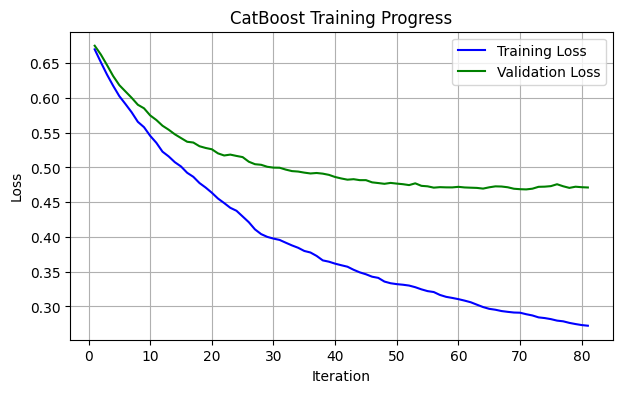

In [16]:
evals_result = model_cat.get_evals_result()
train_loss = evals_result['learn']['Logloss']
test_loss = evals_result['validation']['Logloss']
iterations = np.arange(1, len(train_loss) + 1)
 
plt.figure(figsize=(7, 4))
plt.plot(iterations, train_loss, label='Training Loss', color='blue')
plt.plot(iterations, test_loss, label='Validation Loss', color='green')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('CatBoost Training Progress')
plt.legend()
plt.grid()
plt.show()